In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [28]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]

(2773, 22)


season          School team_id  Games    SRS   SOS  win_pct  pts_avg  \
38    2009  Centenary (LA)     NaN     29 -17.16 -5.08    0.276       70   

    opp_pts_avg  fg_pct  allow_fg_pct  ft_pct  allow_ft_att_avg   poss_avg  \
38           80   0.416          0.49   0.733                25  80.641379   

    off_rebs_avg  allow_off_rebs_avg  def_rebs_avg  allow_def_rebs_avg  \
38             9                  11            20                  27   

    to_avg  steal_avg  off_rating  ft_att_avg  
38      15          7   86.804071          21

In [4]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)

(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [5]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


conf_name
id                                            
fe406882-9f22-495e-9df6-ef357a6803c6       Ivy
ca478771-aa3d-4231-81e0-b70f519134fb       Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34       Ivy
d60357bd-1205-42e9-9092-d986a2843a34       Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692       Ivy

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [6]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)



tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [7]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

win_conf_name  count    percent  cum_percent
3   Atlantic Coast    431  20.358999    20.358999
9          Big Ten    313  14.785073    35.144072
24    Southeastern    269  12.706660    47.850732
5           Big 12    231  10.911667    58.762400
22      Pacific 12    197   9.305621    68.068021

Identify the conferences that have won 70% of all conference games

In [8]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [9]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [10]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['School_t','School_o','Games_t','Games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()




season_t  round   game_date  seed_t                 team_t  \
0      2013     64  2013-03-22       8   North Carolina State   
1      2011     64  2011-03-17       7                 Temple   
2      2013     64  2013-03-21      12                  Akron   
3      2012     64  2012-03-15      12  Virginia Commonwealth   
4      2011      8  2011-03-27       1                 Kansas   

                              team_id_t  seed_o                 team_o  \
0  52df1e19-b142-4a76-a439-ad68455d0581       9                 Temple   
1  8598d1b6-106b-4083-a512-2e495729525a      10             Penn State   
2  56fe0ab2-e4f0-47b9-8726-9ce23ebcde20       5  Virginia Commonwealth   
3  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518       5          Wichita State   
4  fae4855b-1b64-4b40-a632-9ed345e1e952      11  Virginia Commonwealth   

                              team_id_o  game_result  start_season  \
0  8598d1b6-106b-4083-a512-2e495729525a           -1          2012   
1  4aebd148-8119-4875-954c-66779867989b            1          2010   
2  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2012   
3  f38b58de-3273-4723-a78b-2f918e9aa2d5            1          2011   
4  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2010   

  Game Result  SRS_t  SOS_t  win_pct_t  pts_avg_t  opp_pts_avg_t  fg_pct_t  \
0        Lose  14.32   7.17      0.686         77             70     0.496   
1         Win  12.35   4.23      0.765         70             62     0.447   
2        Lose   8.11   0.18      0.788         71             62     0.455   
3         Win   8.79   0.63      0.806         68             59     0.410   
4        Lose  24.10   7.62      0.921         81             64     0.508   

   allow_fg_pct_t  ft_pct_t  allow_ft_att_avg_t  poss_avg_t  off_rebs_avg_t  \
0           0.419     0.681                  17   78.434286              11   
1           0.435     0.698                  19   75.688235              11   
2           0.395     0.643                  19   78.884848              12   
3           0.424     0.685                  18   76.305556              12   
4           0.380     0.679                  18   80.126316              11   

   allow_off_rebs_avg_t  def_rebs_avg_t  allow_def_rebs_avg_t  to_avg_t  \
0                    12              22                    21        12   
1                    11              24                    22        10   
2                    10              21                    21        13   
3                    10              18                    24        11   
4                    10              27                    21        13   

   steal_avg_t  off_rating_t  ft_att_avg_t  season_o  SRS_o  SOS_o  win_pct_o  \
0            6     98.171354            23      2012   9.52   5.20      0.706   
1            6     92.484651            19      2010  11.98  11.45      0.559   
2            7     90.004610            20      2012  16.89   4.47      0.750   
3           10     89.115399            20      2011  17.42   3.80      0.818   
4            7    101.090384            22      2010   8.56   3.78      0.700   

   pts_avg_o  opp_pts_avg_o  fg_pct_o  allow_fg_pct_o  ft_pct_o  \
0         72             67     0.428           0.438     0.723   
1         63             62     0.439           0.434     0.724   
2         76             64     0.450           0.444     0.701   
3         77             62     0.482           0.393     0.748   
4         71             66     0.434           0.424     0.715   

   allow_ft_att_avg_o  poss_avg_o  off_rebs_avg_o  allow_off_rebs_avg_o  \
0                  18   77.494118              11                    10   
1                  21   68.341176               9                     8   
2                  20   81.044444              13                    11   
3                  18   77.496970              10                     9   
4                  18   75.240000              10                    10   

   def_reb

In [11]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

Empty DataFrame
Columns: [SAG, WLK, WOL, Team, RTH, COL, POM, DOL, RPI, MOR, season, win_pct, kaggle_id]
Index: []

In [12]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

season_t  round   game_date  seed_t                 team_t  \
0      2013     64  2013-03-22       8   North Carolina State   
1      2011     64  2011-03-17       7                 Temple   
2      2013     64  2013-03-21      12                  Akron   
3      2012     64  2012-03-15      12  Virginia Commonwealth   
4      2011      8  2011-03-27       1                 Kansas   

                              team_id_t  seed_o                 team_o  \
0  52df1e19-b142-4a76-a439-ad68455d0581       9                 Temple   
1  8598d1b6-106b-4083-a512-2e495729525a      10             Penn State   
2  56fe0ab2-e4f0-47b9-8726-9ce23ebcde20       5  Virginia Commonwealth   
3  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518       5          Wichita State   
4  fae4855b-1b64-4b40-a632-9ed345e1e952      11  Virginia Commonwealth   

                              team_id_o  game_result  start_season  \
0  8598d1b6-106b-4083-a512-2e495729525a           -1          2012   
1  4aebd148-8119-4875-954c-66779867989b            1          2010   
2  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2012   
3  f38b58de-3273-4723-a78b-2f918e9aa2d5            1          2011   
4  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2010   

  Game Result  SRS_t  SOS_t  win_pct_t  pts_avg_t  opp_pts_avg_t  fg_pct_t  \
0        Lose  14.32   7.17      0.686         77             70     0.496   
1         Win  12.35   4.23      0.765         70             62     0.447   
2        Lose   8.11   0.18      0.788         71             62     0.455   
3         Win   8.79   0.63      0.806         68             59     0.410   
4        Lose  24.10   7.62      0.921         81             64     0.508   

   allow_fg_pct_t  ft_pct_t  allow_ft_att_avg_t  poss_avg_t  off_rebs_avg_t  \
0           0.419     0.681                  17   78.434286              11   
1           0.435     0.698                  19   75.688235              11   
2           0.395     0.643                  19   78.884848              12   
3           0.424     0.685                  18   76.305556              12   
4           0.380     0.679                  18   80.126316              11   

   allow_off_rebs_avg_t  def_rebs_avg_t  allow_def_rebs_avg_t  to_avg_t  \
0                    12              22                    21        12   
1                    11              24                    22        10   
2                    10              21                    21        13   
3                    10              18                    24        11   
4                    10              27                    21        13   

   steal_avg_t  off_rating_t  ft_att_avg_t  season_o  SRS_o  SOS_o  win_pct_o  \
0            6     98.171354            23      2012   9.52   5.20      0.706   
1            6     92.484651            19      2010  11.98  11.45      0.559   
2            7     90.004610            20      2012  16.89   4.47      0.750   
3           10     89.115399            20      2011  17.42   3.80      0.818   
4            7    101.090384            22      2010   8.56   3.78      0.700   

   pts_avg_o  opp_pts_avg_o  fg_pct_o  allow_fg_pct_o  ft_pct_o  \
0         72             67     0.428           0.438     0.723   
1         63             62     0.439           0.434     0.724   
2         76             64     0.450           0.444     0.701   
3         77             62     0.482           0.393     0.748   
4         71             66     0.434           0.424     0.715   

   allow_ft_att_avg_o  poss_avg_o  off_rebs_avg_o  allow_off_rebs_avg_o  \
0                  18   77.494118              11                    10   
1                  21   68.341176               9                     8   
2                  20   81.044444              13                    11   
3                  18   77.496970              10                     9   
4                  18   75.240000              10                    10   

   def_reb

In [13]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings.head()

season_t  round   game_date  seed_t                 team_t  \
0      2013     64  2013-03-22       8   North Carolina State   
1      2011     64  2011-03-17       7                 Temple   
2      2013     64  2013-03-21      12                  Akron   
3      2012     64  2012-03-15      12  Virginia Commonwealth   
4      2011      8  2011-03-27       1                 Kansas   

                              team_id_t  seed_o                 team_o  \
0  52df1e19-b142-4a76-a439-ad68455d0581       9                 Temple   
1  8598d1b6-106b-4083-a512-2e495729525a      10             Penn State   
2  56fe0ab2-e4f0-47b9-8726-9ce23ebcde20       5  Virginia Commonwealth   
3  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518       5          Wichita State   
4  fae4855b-1b64-4b40-a632-9ed345e1e952      11  Virginia Commonwealth   

                              team_id_o  game_result  start_season  \
0  8598d1b6-106b-4083-a512-2e495729525a           -1          2012   
1  4aebd148-8119-4875-954c-66779867989b            1          2010   
2  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2012   
3  f38b58de-3273-4723-a78b-2f918e9aa2d5            1          2011   
4  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2010   

  Game Result  SRS_t  SOS_t  win_pct_t  pts_avg_t  opp_pts_avg_t  fg_pct_t  \
0        Lose  14.32   7.17      0.686         77             70     0.496   
1         Win  12.35   4.23      0.765         70             62     0.447   
2        Lose   8.11   0.18      0.788         71             62     0.455   
3         Win   8.79   0.63      0.806         68             59     0.410   
4        Lose  24.10   7.62      0.921         81             64     0.508   

   allow_fg_pct_t  ft_pct_t  allow_ft_att_avg_t  poss_avg_t  off_rebs_avg_t  \
0           0.419     0.681                  17   78.434286              11   
1           0.435     0.698                  19   75.688235              11   
2           0.395     0.643                  19   78.884848              12   
3           0.424     0.685                  18   76.305556              12   
4           0.380     0.679                  18   80.126316              11   

   allow_off_rebs_avg_t  def_rebs_avg_t  allow_def_rebs_avg_t  to_avg_t  \
0                    12              22                    21        12   
1                    11              24                    22        10   
2                    10              21                    21        13   
3                    10              18                    24        11   
4                    10              27                    21        13   

   steal_avg_t  off_rating_t  ft_att_avg_t  season_o  SRS_o  SOS_o  win_pct_o  \
0            6     98.171354            23      2012   9.52   5.20      0.706   
1            6     92.484651            19      2010  11.98  11.45      0.559   
2            7     90.004610            20      2012  16.89   4.47      0.750   
3           10     89.115399            20      2011  17.42   3.80      0.818   
4            7    101.090384            22      2010   8.56   3.78      0.700   

   pts_avg_o  opp_pts_avg_o  fg_pct_o  allow_fg_pct_o  ft_pct_o  \
0         72             67     0.428           0.438     0.723   
1         63             62     0.439           0.434     0.724   
2         76             64     0.450           0.444     0.701   
3         77             62     0.482           0.393     0.748   
4         71             66     0.434           0.424     0.715   

   allow_ft_att_avg_o  poss_avg_o  off_rebs_avg_o  allow_off_rebs_avg_o  \
0                  18   77.494118              11                    10   
1                  21   68.341176               9                     8   
2                  20   81.044444              13                    11   
3                  18   77.496970              10                     9   
4                  18   75.240000              10                    10   

   def_reb

#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [14]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


game_result        conf_name_t        conf_name_o  top_conf
0           -1     Atlantic Coast  American Athletic         1
1            1  American Athletic            Big Ten        -1
2           -1       Mid-American        Atlantic 10         0
3            1        Atlantic 10  American Athletic         0
4           -1             Big 12        Atlantic 10         1
5            1        Atlantic 10     Atlantic Coast        -1
6           -1            Big Ten        Atlantic 10         1
7            1        Atlantic 10           Big East         0
8           -1         Pacific 12        Atlantic 10         1
9            1        Atlantic 10         Pacific 12        -1

In [15]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

season_t  round   game_date  seed_t                 team_t  \
0      2013     64  2013-03-22       8   North Carolina State   
1      2011     64  2011-03-17       7                 Temple   
2      2013     64  2013-03-21      12                  Akron   
3      2012     64  2012-03-15      12  Virginia Commonwealth   
4      2011      8  2011-03-27       1                 Kansas   

                              team_id_t  seed_o                 team_o  \
0  52df1e19-b142-4a76-a439-ad68455d0581       9                 Temple   
1  8598d1b6-106b-4083-a512-2e495729525a      10             Penn State   
2  56fe0ab2-e4f0-47b9-8726-9ce23ebcde20       5  Virginia Commonwealth   
3  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518       5          Wichita State   
4  fae4855b-1b64-4b40-a632-9ed345e1e952      11  Virginia Commonwealth   

                              team_id_o  game_result  start_season  \
0  8598d1b6-106b-4083-a512-2e495729525a           -1          2012   
1  4aebd148-8119-4875-954c-66779867989b            1          2010   
2  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2012   
3  f38b58de-3273-4723-a78b-2f918e9aa2d5            1          2011   
4  c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518           -1          2010   

  Game Result  SRS_t  SOS_t  win_pct_t  pts_avg_t  opp_pts_avg_t  fg_pct_t  \
0        Lose  14.32   7.17      0.686         77             70     0.496   
1         Win  12.35   4.23      0.765         70             62     0.447   
2        Lose   8.11   0.18      0.788         71             62     0.455   
3         Win   8.79   0.63      0.806         68             59     0.410   
4        Lose  24.10   7.62      0.921         81             64     0.508   

   allow_fg_pct_t  ft_pct_t  allow_ft_att_avg_t  poss_avg_t  off_rebs_avg_t  \
0           0.419     0.681                  17   78.434286              11   
1           0.435     0.698                  19   75.688235              11   
2           0.395     0.643                  19   78.884848              12   
3           0.424     0.685                  18   76.305556              12   
4           0.380     0.679                  18   80.126316              11   

   allow_off_rebs_avg_t  def_rebs_avg_t  allow_def_rebs_avg_t  to_avg_t  \
0                    12              22                    21        12   
1                    11              24                    22        10   
2                    10              21                    21        13   
3                    10              18                    24        11   
4                    10              27                    21        13   

   steal_avg_t  off_rating_t  ft_att_avg_t  season_o  SRS_o  SOS_o  win_pct_o  \
0            6     98.171354            23      2012   9.52   5.20      0.706   
1            6     92.484651            19      2010  11.98  11.45      0.559   
2            7     90.004610            20      2012  16.89   4.47      0.750   
3           10     89.115399            20      2011  17.42   3.80      0.818   
4            7    101.090384            22      2010   8.56   3.78      0.700   

   pts_avg_o  opp_pts_avg_o  fg_pct_o  allow_fg_pct_o  ft_pct_o  \
0         72             67     0.428           0.438     0.723   
1         63             62     0.439           0.434     0.724   
2         76             64     0.450           0.444     0.701   
3         77             62     0.482           0.393     0.748   
4         71             66     0.434           0.424     0.715   

   allow_ft_att_avg_o  poss_avg_o  off_rebs_avg_o  allow_off_rebs_avg_o  \
0                  18   77.494118              11                    10   
1                  21   68.341176               9                     8   
2                  20   81.044444              13                    11   
3                  18   77.496970              10                     9   
4                  18   75.240000              10                    10   

   def_reb

In [16]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','team_t','team_id_t','team_id_o',
                                         'team_o','team_id_o','game_result','start_season','Game Result',
                                         'conf_name_t','conf_name_o']).copy()
feature_data.head()

season_t  seed_t  seed_o  SRS_t  SOS_t  win_pct_t  pts_avg_t  \
0      2013       8       9  14.32   7.17      0.686         77   
1      2011       7      10  12.35   4.23      0.765         70   
2      2013      12       5   8.11   0.18      0.788         71   
3      2012      12       5   8.79   0.63      0.806         68   
4      2011       1      11  24.10   7.62      0.921         81   

   opp_pts_avg_t  fg_pct_t  allow_fg_pct_t  ft_pct_t  allow_ft_att_avg_t  \
0             70     0.496           0.419     0.681                  17   
1             62     0.447           0.435     0.698                  19   
2             62     0.455           0.395     0.643                  19   
3             59     0.410           0.424     0.685                  18   
4             64     0.508           0.380     0.679                  18   

   poss_avg_t  off_rebs_avg_t  allow_off_rebs_avg_t  def_rebs_avg_t  \
0   78.434286              11                    12              22   
1   75.688235              11                    11              24   
2   78.884848              12                    10              21   
3   76.305556              12                    10              18   
4   80.126316              11                    10              27   

   allow_def_rebs_avg_t  to_avg_t  steal_avg_t  off_rating_t  ft_att_avg_t  \
0                    21        12            6     98.171354            23   
1                    22        10            6     92.484651            19   
2                    21        13            7     90.004610            20   
3                    24        11           10     89.115399            20   
4                    21        13            7    101.090384            22   

   season_o  SRS_o  SOS_o  win_pct_o  pts_avg_o  opp_pts_avg_o  fg_pct_o  \
0      2012   9.52   5.20      0.706         72             67     0.428   
1      2010  11.98  11.45      0.559         63             62     0.439   
2      2012  16.89   4.47      0.750         76             64     0.450   
3      2011  17.42   3.80      0.818         77             62     0.482   
4      2010   8.56   3.78      0.700         71             66     0.434   

   allow_fg_pct_o  ft_pct_o  allow_ft_att_avg_o  poss_avg_o  off_rebs_avg_o  \
0           0.438     0.723                  18   77.494118              11   
1           0.434     0.724                  21   68.341176               9   
2           0.444     0.701                  20   81.044444              13   
3           0.393     0.748                  18   77.496970              10   
4           0.424     0.715                  18   75.240000              10   

   allow_off_rebs_avg_o  def_rebs_avg_o  allow_def_rebs_avg_o  to_avg_o  \
0                    10              19                    25        10   
1                     8              21                    23        10   
2                    11              18                    23        11   
3                     9              24                    21        12   
4                    10              21                    24        11   

   steal_avg_o  off_rating_o  ft_att_avg_o  SAG_t  WLK_t  WOL_t  RTH_t  COL_t  \
0            7     92.910278            20     25   27.0     36     28   32.0   
1            4     92.184541            16     32   30.0     25     32   27.0   
2           11     93.775706            18     62   55.0     52     59   50.0   
3            6     99.358724            19     50   43.0     32     54   35.0   
4            8     94.364700            20      2    2.0      3      2    1.0   

   POM_t  DOL_t  RPI_t  MOR_t  SAG_o  WLK_o  WOL_o  RTH_o  COL_o  POM_o  \
0   35.0   32.0   33.0     24     55   58.0     35     47   40.0   68.0   
1   38.0   25.0   30.0     45     45   42.0     43     37   39.0   39.0   
2   54.0   46.0   42.0     60     26   19.0     27     27   27.0   21.0   
3   47.0   33.0   38.0     55     10   10.0     16     16   11.0   10.0   
4 

In [17]:
feature_data_diff = feature_data.copy()
feature_data_diff['margin_victory_t'] = feature_data_diff['pts_avg_t'] - feature_data_diff['opp_pts_avg_t']
feature_data_diff['margin_victory_o'] = feature_data_diff['pts_avg_o'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['delta_margin_victory_avg'] = feature_data_diff['margin_victory_t'] - feature_data_diff['margin_victory_o']

feature_data_diff['delta_fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']

#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['delta_off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['delta_def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['delta_allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['delta_ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']

feature_data_diff['to_net_avg_t'] = feature_data_diff['to_avg_t'] - feature_data_diff['steal_avg_t']
feature_data_diff['to_net_avg_o'] = feature_data_diff['to_avg_o'] - feature_data_diff['steal_avg_o']
feature_data_diff['delta_to_net_avg'] = feature_data_diff['to_net_avg_t'] - feature_data_diff['to_net_avg_o']

feature_data_diff['delta_win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['delta_off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['delta_allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['delta_ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']

feature_data_diff['delta_allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['seed_t'] - feature_data_diff['seed_o']

feature_data_diff['delta_srs'] = feature_data_diff['SRS_t'] - feature_data_diff['SRS_o']
feature_data_diff['delta_sos'] = feature_data_diff['SOS_t'] - feature_data_diff['SOS_o']

feature_data_diff['delta_sag'] = feature_data_diff['SAG_t'] - feature_data_diff['SAG_o']
feature_data_diff['delta_wlk'] = feature_data_diff['WLK_t'] - feature_data_diff['WLK_o']
feature_data_diff['delta_wol'] = feature_data_diff['WOL_t'] - feature_data_diff['WOL_o']
feature_data_diff['delta_rth'] = feature_data_diff['RTH_t'] - feature_data_diff['RTH_o']
feature_data_diff['delta_col'] = feature_data_diff['COL_t'] - feature_data_diff['COL_o']
feature_data_diff['delta_pom'] = feature_data_diff['POM_t'] - feature_data_diff['POM_o']
feature_data_diff['delta_dol'] = feature_data_diff['DOL_t'] - feature_data_diff['DOL_o']
feature_data_diff['delta_rpi'] = feature_data_diff['RPI_t'] - feature_data_diff['RPI_o']
feature_data_diff['delta_mor'] = feature_data_diff['MOR_t'] - feature_data_diff['MOR_o']


feature_data_diff.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_t', 'margin_victory_o',
                                'poss_avg_t','poss_avg_o',
                                'seed_t','seed_o','season_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'SRS_t','SRS_o','SOS_t','SOS_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'SAG_t','SAG_o','WLK_t','WLK_o','WOL_t','WOL_o',
                                'RTH_t','RTH_o','COL_t','COL_o','POM_t','POM_o',
                                'DOL_t','DOL_o','RPI_t','RPI_o','MOR_t','MOR_o'], inplace=True)

In [18]:
X= feature_data_diff[feature_data_diff['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_allow_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_allow_off_rebs_avg',
 'delta_ft_att_avg',
 'delta_allow_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 26)
(426,)
(107, 26)
(107,)


top_conf  upset_seed_threshold  delta_margin_victory_avg  delta_fg_pct  \
140         0                     1                         2         0.069   
293         0                     0                        -3         0.000   
368        -1                     1                        -4         0.032   
53          1                     1                         5        -0.006   
33          0                     0                         1        -0.007   

     delta_off_rebs_avg  delta_def_rebs_avg  delta_allow_def_rebs_avg  \
140                  -2                  -2                        -6   
293                   1                   0                        -4   
368                  -3                   1                        -1   
53                    7                   3                        -1   
33                   -1                   0                        -1   

     delta_ft_pct  delta_to_net_avg  delta_win_pct  delta_off_rating  \
140        -0.008                 2          0.081          5.170601   
293        -0.044                 3          0.030         -5.202764   
368         0.016                 2         -0.132          4.187608   
53         -0.085                 0          0.118         -4.527964   
33          0.034                -1         -0.015         -0.684009   

     delta_allow_off_rebs_avg  delta_ft_att_avg  delta_allow_ft_att_avg  \
140                        -1                -4                      -2   
293                        -4                 0                      -1   
368                         0                -7                       1   
53                          1                 5                       5   
33                         -1                -1                      -3   

     delta_seed  delta_srs  delta_sos  delta_sag  delta_wlk  delta_wol  \
140         -11      12.47       9.59       -101      -82.0       -105   
293           1      -2.42       0.22         10       14.0          5   
368           9     -14.49      -8.53         82       88.0         90   
53           -8       9.67       4.01        -56      -71.0        -63   
33            2      -2.73      -3.85          7        9.0          3   

     delta_rth  delta_col  delta_pom  delta_dol  delta_rpi  delta_mor  
140       -107      -94.0      -89.0     -110.0      -88.0        -94  
293          3        3.0       14.0        1.0        4.0          8  
368        101       92.0       76.0       98.0       67.0         90  
53         -71      -74.0      -60.0      -68.0      -53.0        -54  
33           8        5.0        6.0       10.0        6.0         16

#### Baseline Model

In [20]:
number_estimators = 401

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators)
    
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  1.0


In [21]:
importances = bdt.feature_importances_
important_features = utils.display_important_features(importances, X_train)

Coefficient Values
delta_win_pct   0.14214463840399003
delta_sos   0.14214463840399003
delta_fg_pct   0.07231920199501247
delta_ft_pct   0.06483790523690773
delta_dol   0.06234413965087282
delta_rth   0.059850374064837904
delta_srs   0.05486284289276808
delta_mor   0.04987531172069826
delta_wlk   0.03740648379052369
delta_rpi   0.03740648379052369
delta_pom   0.032418952618453865
delta_seed   0.029925187032418952
delta_sag   0.029925187032418952
delta_allow_def_rebs_avg   0.022443890274314215
delta_off_rating   0.022443890274314215
delta_allow_off_rebs_avg   0.0199501246882793
delta_ft_att_avg   0.0199501246882793
delta_wol   0.0199501246882793
delta_col   0.0199501246882793
delta_margin_victory_avg   0.014962593516209476
delta_def_rebs_avg   0.012468827930174564
delta_to_net_avg   0.012468827930174564
delta_allow_ft_att_avg   0.00997506234413965
delta_off_rebs_avg   0.007481296758104738
top_conf   0.0024937655860349127
upset_seed_threshold   0.0


In [22]:
y_pred = bdt.predict(X_test)
print("RF model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

RF model accuracy is 0.72


array([[41, 11],
       [19, 36]], dtype=int64)

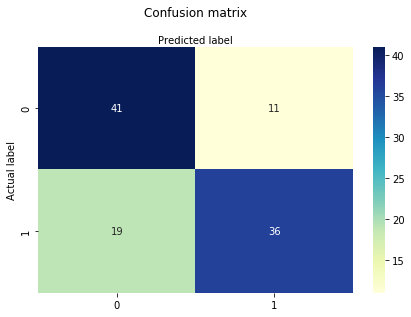

In [23]:
utils.display_confusion_matrix(y_test, y_pred)

##### Baseline Confusion Matrix

In [24]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.719626168224299
Precision: 0.7659574468085106
Recall: 0.6545454545454545
Log loss=  0.6807683378751304


In [25]:
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7621848626565607


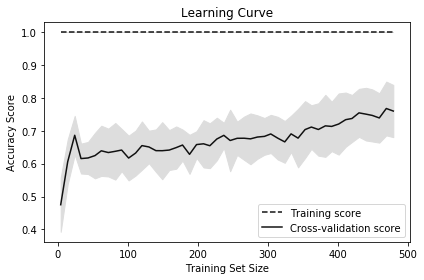

In [26]:
train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

                   Baseline Learning Curve

#### Model Feature Optimization

In [29]:
X = feature_data_diff[feature_data_diff['season_t']>=2010]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

model_stats = eliminate_features(bdt, X,y)
#print(model_stats)

Iteration=  0
least_important label=  upset_seed_threshold
Iteration=  1
least_important label=  top_conf
Iteration=  2
least_important label=  delta_off_rebs_avg
Iteration=  3
least_important label=  delta_allow_ft_att_avg
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_def_rebs_avg
Iteration=  6
least_important label=  delta_margin_victory_avg
Iteration=  7
least_important label=  delta_col
Iteration=  8
least_important label=  delta_wol
Iteration=  9
least_important label=  delta_ft_att_avg
Iteration=  10
least_important label=  delta_allow_off_rebs_avg
Iteration=  11
least_important label=  delta_off_rating
Iteration=  12
least_important label=  delta_allow_def_rebs_avg
Iteration=  13
least_important label=  delta_sag
Iteration=  14
least_important label=  delta_seed
Iteration=  15
least_important label=  delta_pom
Iteration=  16
least_important label=  delta_rpi
Iteration=  17
least_important label=  delta_wlk
Iteration=  18
least

In [30]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7196 Cross Val= 0.7603  Log Loss= 0.6808
Accuracy= 0.7196 Cross Val= 0.7622  Log Loss= 0.6808
Accuracy= 0.7196 Cross Val= 0.7567  Log Loss= 0.6804
Accuracy= 0.7009 Cross Val= 0.7433  Log Loss= 0.6834
Accuracy= 0.6916 Cross Val= 0.7285  Log Loss= 0.6829
Accuracy= 0.6822 Cross Val= 0.7379  Log Loss= 0.6830
Accuracy= 0.6916 Cross Val= 0.7550  Log Loss= 0.6828
Accuracy= 0.6916 Cross Val= 0.7565  Log Loss= 0.6823
Accuracy= 0.7009 Cross Val= 0.7547  Log Loss= 0.6832
Accuracy= 0.7009 Cross Val= 0.7622  Log Loss= 0.6833
Accuracy= 0.6822 Cross Val= 0.7586  Log Loss= 0.6827
Accuracy= 0.6822 Cross Val= 0.7473  Log Loss= 0.6833
Accuracy= 0.7290 Cross Val= 0.7625  Log Loss= 0.6830
Accuracy= 0.7383 Cross Val= 0.7905  Log Loss= 0.6828
Accuracy= 0.7290 Cross Val= 0.7661  Log Loss= 0.6823
Accuracy= 0.7383 Cross Val= 0.7867  Log Loss= 0.6824
Accuracy= 0.7009 Cross Val= 0.7886  Log Loss= 0.6827
Accuracy= 0.7383 Cross Val= 0.7753  Log Loss= 0.6821
Accuracy= 0.7570 Cross Val= 0.7755  Log Loss= 

In [31]:
labels = model_stats[cross_hash]['labels']
print(labels)

['delta_fg_pct', 'delta_ft_pct', 'delta_win_pct', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_rth', 'delta_pom', 'delta_dol', 'delta_rpi', 'delta_mor']


In [32]:
X = feature_data_diff[feature_data_diff['season_t']>=2010][labels]


array([[39, 13],
       [15, 40]], dtype=int64)

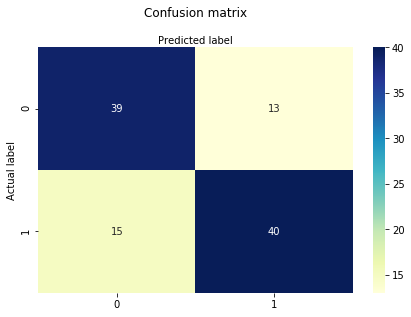

In [33]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
bdt.fit(X_train, y_train)
y_pred = bdt.predict(X_test)
# save model stats
prediction_probabilities = bdt.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



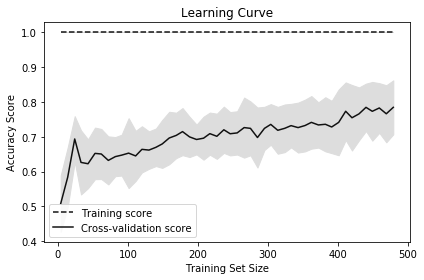

In [34]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [35]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()


test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

#test_games['game_result'] = test_games.game_result.apply(negate_loser)

test_games.shape

(107, 73)

In [36]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])

#base_prediction_labels = ['predicted_result','game_result','pred_win_prob','team_t','seed_t','conf_name_t', 'team_o',
#                    'seed_o', 'conf_name_o','top_conf','season_t','round']


missed_predictions

Missed predictions=  28


season_t  round   game_date  seed_t          team_t  \
358      2015     32  2015-03-21       1       Villanova   
488      2016     64  2016-03-18       3   West Virginia   
52       2010     64  2010-03-19      12      Utah State   
494      2012     64  2012-03-16       7    Saint Mary's   
454      2016     68  2016-03-16      11           Tulsa   
352      2011     64  2011-03-17      12      Utah State   
514      2013     16  2013-03-28       2      Miami (FL)   
432      2013     32  2013-03-24       7        Illinois   
394      2013     32  2013-03-24      12        Ole Miss   
286      2014     32  2014-03-22      12         Harvard   
496      2017     32  2017-03-18       5      Iowa State   
440      2012     64  2012-03-16       7      Notre Dame   
292      2010      8  2010-03-28       6       Tennessee   
281      2013     32  2013-03-23       9   Wichita State   
319      2011      8  2011-03-27       4        Kentucky   
197      2016     64  2016-03-17       9          Butler   
329      2012      2  2012-04-02       1        Kentucky   
191      2013     16  2013-03-28       2      Ohio State   
43       2017     64  2017-03-16       7    Saint Mary's   
203      2011     32  2011-03-19       8          Butler   
123      2016     32  2016-03-20       7       Wisconsin   
407      2016     32  2016-03-19       1  North Carolina   
517      2011     32  2011-03-20      11       Marquette   
71       2011     64  2011-03-17      13  Morehead State   
445      2015     32  2015-03-21       6          Xavier   
51       2017     68  2017-03-15      16        UC Davis   
321      2011     16  2011-03-25       4        Kentucky   
163      2015     68  2015-03-17      16         Hampton   

                                team_id_t  seed_o                  team_o  \
358  4383eb6a-7fd8-4ff2-94c5-43c933121e88       8    North Carolina State   
488  f770d3a2-221c-49ce-9c7a-680f7417fe9e      14       Stephen F. Austin   
52   7672ff16-8436-47e6-8546-0fb5494ec7ee       5               Texas A&M   
494  b18f34af-a7f1-4659-a2e5-fc11a31cd316      10                  Purdue   
454  2959bd24-7007-41ae-a3a3-abdf26888cfc      11                Michigan   
352  7672ff16-8436-47e6-8546-0fb5494ec7ee       5            Kansas State   
514  7aec5187-cb1b-45e5-8f7d-406d766cdc73       3               Marquette   
432  150148c2-ca8f-414f-8f41-d94a55d4a122       2              Miami (FL)   
394  d7d668ec-edaa-4d6b-be25-2ebba4128643      13                La Salle   
286  5c7bf63f-bc39-43c5-9907-73b50b7a6b34       4          Michigan State   
496  0e4258fa-3154-4c16-b693-adecab184c6c       4                  Purdue   
440  80962f09-8821-48b6-8cf0-0cf0eea56aa8      10                  Xavier   
292  b827dbdf-230f-4916-9703-3bb9004e26eb       5          Michigan State   
281  f38b58de-3273-4723-a78b-2f918e9aa2d5       1                 Gonzaga   
319  2267a1f4-68f6-418b-aaf6-2aa0c4b291f1       2          North Carolina   
197  bdb7d7a4-45f8-4bf3-ab85-15488c451494       8              Texas Tech   
329  2267a1f4-68f6-418b-aaf6-2aa0c4b291f1       2                  Kansas   
191  857462b3-0ab6-4d26-9669-10ca354e382b       6                 Arizona   
43   b18f34af-a7f1-4659-a2e5-fc11a31cd316      10   Virginia Commonwealth   
203  bdb7d7a4-45f8-4bf3-ab85-15488c451494       1              Pittsburgh   
123  c7569eae-5b93-4197-b204-6f3a62146b25       2                  Xavier   
407  e9ca48b2-00ba-41c0-a02b-6885a2da1ff1       9              Providence   
517  06f7c904-0ac7-4125-b0f4-f4871bb69057       3                Syracuse   
71   b7747a03-c85b-4de6-94bf-1b5b68553248       4              Louisville   
445  0d8a328f-20ce-410b-bed1-15fc01308aaf      14           Georgia State   
51   8aaad1c0-d16e-4b9f-8541-dac670addd71      16  North Carolina Central   
321  2267a1f4-68f6-418b-aaf6-2aa0c4b291f1       1              Ohio State   
163  161354af-1f3e-4d58-88f7-e016ec74b7b6      16               Manhattan   

                              

In [37]:
result = missed_predictions[0:].apply(lambda x: utils.print_game_info(test_games, x['season_t'], x['round'], x['team_t']), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
Allow FG %                      40.60                              40.30         True  (L)
Turnover Avg                    10.00                              10.00         True  (L)
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        Fal

In [38]:
for key,val in result[0:].items():
     print("key={}  value= {}".format(key, val[1][1]))


key=358  value= True
key=488  value= True
key=52  value= True
key=494  value= True
key=454  value= True
key=352  value= True
key=514  value= True
key=432  value= True
key=394  value= True
key=286  value= True
key=496  value= True
key=440  value= True
key=292  value= True
key=281  value= True
key=319  value= True
key=197  value= True
key=329  value= True
key=191  value= True
key=43  value= True
key=203  value= True
key=123  value= True
key=407  value= True
key=517  value= True
key=71  value= True
key=445  value= True
key=51  value= True
key=321  value= True
key=163  value= True


In [39]:
correct_predictions = test_games[test_games['game_result'] == 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Correct predictions= ", correct_predictions.shape[0])

correct_predictions

Correct predictions=  79


season_t  round   game_date  seed_t                 team_t  \
343      2017     64  2017-03-16       1              Villanova   
333      2015     32  2015-03-21       1               Kentucky   
107      2010     64  2010-03-19       1               Syracuse   
353      2010     64  2010-03-18       2           Kansas State   
383      2015     64  2015-03-20       2               Virginia   
473      2011     64  2011-03-18       1                   Duke   
511      2017     68  2017-03-14      16       Mount St. Mary's   
427      2016     64  2016-03-18       5               Maryland   
155      2011     32  2011-03-19       3            Connecticut   
199      2011      8  2011-03-26       8                 Butler   
237      2016     64  2016-03-18       7                   Iowa   
317      2010     16  2010-03-25       1               Kentucky   
375      2013     32  2013-03-23       1             Louisville   
373      2013      2  2013-04-08       1             Louisville   
457      2013      8  2013-03-31       4               Michigan   
435      2016     32  2016-03-19       3             Miami (FL)   
401      2012     64  2012-03-16       3          Florida State   
279      2013     64  2013-03-21       9          Wichita State   
513      2011     64  2011-03-18      11              Marquette   
223      2010     64  2010-03-19       8                Gonzaga   
149      2014     32  2014-03-22       7            Connecticut   
363      2014     64  2014-03-20       5            Saint Louis   
111      2013     64  2013-03-22      12               Ole Miss   
145      2014     64  2014-03-20      12                Harvard   
477      2010     16  2010-03-26       1                   Duke   
49       2012     64  2012-03-15       5             New Mexico   
201      2015     64  2015-03-19       6                 Butler   
283      2013      8  2013-03-30       9          Wichita State   
7        2011     64  2011-03-18      11  Virginia Commonwealth   
285      2014     16  2014-03-28       4         Michigan State   
..        ...    ...         ...     ...                    ...   
430      2012     68  2012-03-14      16                  Lamar   
176      2012     64  2012-03-16      11                  Texas   
456      2011     64  2011-03-18       9              Tennessee   
56       2015     64  2015-03-20       9             St. John's   
28       2012     64  2012-03-16       5                 Temple   
412      2016      8  2016-03-27       6             Notre Dame   
304      2011     64  2011-03-18      12                Memphis   
248      2013     32  2013-03-24       8         North Carolina   
490      2011     68  2011-03-16      16          Alabama State   
34       2017     32  2017-03-19      11           Rhode Island   
316      2016     64  2016-03-17      13            Stony Brook   
482      2013     32  2013-03-24       7              Creighton   
366      2012     64  2012-03-15       6                   UNLV   
448      2014     32  2014-03-23      14                 Mercer   
282      2017     64  2017-03-17       7                 Dayton   
250      2012     16  2012-03-23      11   North Carolina State   
40       2013     68  2013-03-20      16           LIU Brooklyn   
208      2010     16  2010-03-25       1               Syracuse   
298      2013     64  2013-03-21      14             Valparaiso   
162      2010     32  2010-03-20       3             New Mexico   
336      2014     64  2014-03-21       9           Kansas State   
300      2012     64  2012-03-16      16           LIU Brooklyn   
508      2017     32  2017-03-18       5             Notre Dame   
134      2015     64  2015-03-20      16       Coastal Carolina   
344      2010     64  2010-03-18      15          Robert Morris   
436      2016     64  2016-03-18      15            Weber State   
278      2014     64  2014-03-21      16               Cal Poly   
244      2012     64  2012-03-16      15            

In [40]:
result = bdt.decision_function(X_train)
print(result)

[-0.05426017  0.01215584 -0.05814515  0.01477982  0.00756659 -0.17060094
  0.12056365 -0.02214716  0.12023718 -0.04082704  0.031062   -0.11376042
 -0.01159684 -0.0180599   0.05161458 -0.01454739 -0.02006184  0.01267839
 -0.04493119  0.01391474 -0.03617689  0.01742498 -0.0201053   0.01420705
 -0.01457175  0.13483605  0.01945608  0.01158805  0.04909381  0.02288381
  0.01661488 -0.01912979 -0.01156142 -0.11407341  0.0295892  -0.0210529
  0.02038786 -0.01704327  0.00738627  0.03228907  0.01664625 -0.02459465
  0.01683481  0.04433181 -0.02378751  0.01084146 -0.02227266 -0.02137623
  0.00974968 -0.1150796  -0.07589074  0.02849207 -0.04249997 -0.01426693
  0.07319448 -0.02383081  0.01080771 -0.05747176 -0.08177646 -0.01235686
 -0.02081624 -0.01975023  0.02003379 -0.14147945  0.02681467  0.03989853
  0.09438919 -0.03963124 -0.0771878   0.10218132 -0.03595703  0.03371324
  0.05063297 -0.01998926  0.07748484 -0.02238718  0.01687953 -0.04343643
  0.01881958 -0.07306964  0.1181282  -0.01717733 -0.